# Auxiliary Meteorological Data
## ECMWF Integrated Forecast System (IFS) shortrange forecast data for the Aeolus track

> Abstract: Access to AUX_MET product and its visualization

## Load packages, modules and extensions

In [1]:
# enable following line for interactive visualization backend for matplotlib
# %matplotlib widget
# print version info
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.3
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
from viresclient import AeolusRequest
import numpy as np
from netCDF4 import num2date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

## Product information

The Rayleigh winds of Aeolus have a sensitivity to atmospheric temperature and pressure, which is caused by the Rayleigh-Brillouin scattering and leads to frequency broadening of laser light backscattered by molecules. 
This must be corrected in the data processing. However, the atmospheric temperature and pressure along the lidar line-of-sight is in general unknown during the time of the L1B processing. Thus the output from the molecular channel will be given for a standard temperature and pressure profile. This simplification is corrected during the Level 2 processing, making use of NWP 6-h forecast information from ECMWF's Integrated Forecast System (IFS).

Documentation:
- https://earth.esa.int/eogateway/documents/20142/37627/Aeolus-Sensor-and-Product-Description.pdf
- https://earth.esa.int/eogateway/documents/20142/37627/Aeolus-L2B-2C-Input-Output-DD-ICD.pdf


### AUX_MET parameters on VirES

Many of the parameters of the Auxiliary Meteorological Data (AMD) product can be obtained via the viresclient. A list of selected parameters can be found in the following table. For a complete list, please refer to the web client which lists the available parameters under the "Data" tab or use the "print_available_collections()"-method of an AeolusRequest instance. For an explanation of the parameters, please refer to the VirES web client or the documentation (Input-Output-DD).  
The parameters are available specifically for nadir and off-nadir viewing geometry. They are not explicitly listed for both of them.
A description of the parameters in the table is shown as tooltip when hovering the parameter name.

| Parameter | Unit |
|:----------|:----:|
|[time](## "AMD datetime")   | UTC |
|[latitude](## "Latitude for each profile")        | DegN |
|[longitude](## "Longitude for each profile")        | DegE |
|[surface_wind_component_u](## "East-West wind component at the surface (>0 to East) for each profile")        | cm/s |
|[surface_wind_component_u](## "North-South wind component at the surface (>0 to North) for each profile")        | cm/s |
|[surface_pressure](## "Surface pressure")        | Pa |
|[surface_altitude](## "Geometric height relative to EGM96 geoid at surface pressure. Gives the altitude of the surface according to the weather model for each profile")        | cm |
|[layer_pressure](## "Nominal pressure within the model layer - one value for each model layer per profile")        | Pa |
|[layer_altitude](## "Geometric height relative to EGM96 geoid at layer pressure - one value for each model layer per profile")        | cm |
|[layer_validity_flag](## "0 for a valid level with a complete set of AMD data with all parameters extracted from the NWP model ; -1 for an incomplete level containing at least valid temperature, valid pressures, and valid heights ; -2 otherwise")        |  |
|[layer_temperature](## "Layer temperature")        | 10⁻² K |
|[layer_wind_component_u](## "Layer East-West wind velocity (>0 to East)")        | cm/s |
|[layer_wind_component_v](## "Layer North-South wind velocity (>0 to North)")        | cm/s |
|[layer_rel_humidity](## "Layer relative humidity")        | % |
|[layer_spec_humidity](## "Layer specific humidity")        | kg/kg |
|[layer_cloud_cover](## "Layer cloud cover")        | % |
|[layer_cloud_liquid_water_content](## "Layer cloud liquid water content")        | kg/kg |
|[layer_cloud_ice_water_content](## "Layer cloud ice water content")        | kg/kg |

## Defining product, parameters and time for the data request
Keep in mind that the time for **one full orbit** is around **90 minutes**.
The **repeat cycle** of the orbits is **7 days**.

In [3]:
# Aeolus product
DATA_PRODUCT = "AUX_MET_12"

# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start = "2021-10-20T00:00:00Z"
measurement_stop = "2021-10-20T01:30:00Z"

### Define parameter

In [4]:
# off-nadir parameter
parameter_off_nadir = [
    "time",
    "latitude",
    "longitude",
    "surface_altitude",
    "layer_altitude",
    "layer_temperature",
    "layer_cloud_cover",
    "layer_wind_component_u",
    "layer_wind_component_v",
    "layer_rel_humidity",
    "layer_validity_flag",
]
parameter_off_nadir = [param + "_off_nadir" for param in parameter_off_nadir]

# nadir parameter
parameter_nadir = []
parameter_nadir = [param + "_nadir" for param in parameter_nadir]

# combine parameter
parameter_list = parameter_off_nadir + parameter_nadir

## Retrieve data from VRE server

In [5]:
# Data request for AUX_MET product
request = AeolusRequest()

request.set_collection(DATA_PRODUCT)

# set fields
request.set_fields(
    fields=parameter_list,
)

# set start and end time and request data
data_aux_met = request.get_between(
    start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
)
# Save data as xarray data set
ds_aux_met = data_aux_met.as_xarray()

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (3.85MB)

## Plot overview map

Text(0.5, 1.0, 'Aeolus orbit \n from 2021-10-20T00:00:00Z to 2021-10-20T01:30:00Z')

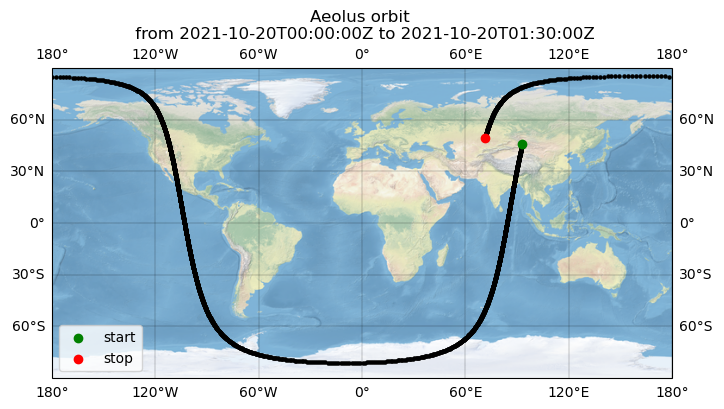

In [6]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
ax.scatter(
    ds_aux_met["longitude_off_nadir"],
    ds_aux_met["latitude_off_nadir"],
    marker="o",
    c="k",
    s=5,
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_aux_met["longitude_off_nadir"][0],
    ds_aux_met["latitude_off_nadir"][0],
    marker="o",
    c="g",
    edgecolor="g",
    label="start",
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_aux_met["longitude_off_nadir"][-1],
    ds_aux_met["latitude_off_nadir"][-1],
    marker="o",
    c="r",
    edgecolor="r",
    label="stop",
    transform=ccrs.Geodetic(),
)
ax.legend()
ax.set_title("Aeolus orbit \n from {} to {}".format(measurement_start, measurement_stop))

## Add datetime variable to the data sets

In [7]:
if "time_off_nadir" in ds_aux_met:
    ds_aux_met["datetime_off_nadir"] = (
        ("off_nadir"),
        num2date(
            ds_aux_met["time_off_nadir"],
            units="s since 2000-01-01",
            only_use_cftime_datetimes=False,
        ),
    )
if "time_nadir" in ds_aux_met:
    ds_aux_met["datetime_nadir"] = (
        ("nadir"),
        num2date(
            ds_aux_met["time_nadir"], units="s since 2000-01-01", only_use_cftime_datetimes=False
        ),
    )

## Add top and bottom altitude
Altitude is given as center of layers. For pcolormesh plots it is necessary to have the boundaries of each level.

In [8]:
# calculate layer top altitudes
layer_altitude_top = (
    ds_aux_met["layer_altitude_off_nadir"][:, :-1].data
    - ds_aux_met["layer_altitude_off_nadir"][:, :].diff(dim="array_137").data / 2.0
)

# calculate layer bottom altitudes
layer_altitude_bottom = (
    ds_aux_met["layer_altitude_off_nadir"][:, 1:].data
    + ds_aux_met["layer_altitude_off_nadir"][:, :].diff(dim="array_137").data / 2.0
)

# combine bottom and top altitude to get layer borders
layer_altitude_borders = np.concatenate((layer_altitude_top, layer_altitude_bottom[:, -2:]), axis=1)
ds_aux_met["layer_altitude_borders_off_nadir"] = (
    ("off_nadir", "array_138"),
    layer_altitude_borders,
)

## Plot parameter
A class for interactive plotting of AUX_MET data.

In [9]:
class PlotData:
    """
    Class for plotting AUX_MET data

    Parameters
    ----------
    dataset : xarray data set
        Which data set to plot.
    """

    def __init__(self, dataset):
        self.ds = dataset

    def select_parameter(self, parameter, viewing_geometry="off-nadir"):
        """Selects the parameter data for plotting. Viewing geometry can be nadir or off-nadir."""
        self.viewing_geometry = viewing_geometry
        if viewing_geometry == "off-nadir":
            self.parameter = parameter + "_off_nadir"
        elif viewing_geometry == "nadir":
            self.parameter = parameter + "_nadir"
        self.parameter_data = np.copy(self.ds[self.parameter].data)
        if hasattr(self.ds[self.parameter], "units"):
            self.parameter_unit = self.ds[self.parameter].units
        else:
            self.parameter_unit = "a.u."

    def select_validity_flag(self):
        """Select the corresponding validity flag for the parameter"""
        if self.viewing_geometry == "off-nadir":
            validity_flag = self.ds["layer_validity_flag_off_nadir"]
        elif self.viewing_geometry == "nadir":
            validity_flag = self.ds["layer_validity_flag_nadir"]
        return validity_flag.data

    def apply_QC_filter(self):
        """
        Applies the QC filter depending on validity flag.
        """
        validity_flag = self.select_validity_flag()
        self.parameter_data.astype(float)[validity_flag[:, :] == -2] = np.nan

    def determine_vmin_vmax(self, z, vmin=None, vmax=None, percentile=99):
        """
        Determines limit values for plots

        """
        if vmin is None:
            vmin = 0
        if vmax is None:
            vmax = np.nanpercentile(z, percentile)
        return vmin, vmax

    def determine_ymax(self, altitude_array, max_altitude):
        """
        Determines the range bin corresponding to the max_altitude (in km)
        """
        ymax = np.mean(np.argmin(np.abs(altitude_array.data - max_altitude), axis=1)).astype(int)
        return ymax

    def determine_xyz(self, start_bin, end_bin, max_altitude, intermediate_profiles_to_skip):
        """
        Determines time parameter (x), altitude parameter (y) and
        parameter of interest (z) for the pcolormesh plot.
        In addition, the altitude center of range bins is provided for profile plots.
        The parameters are sliced according to start_bin and end_bin.
        Altitude parameter is scaled to km instead of m.
        """
        if self.viewing_geometry == "off-nadir":
            x = self.ds["datetime_off_nadir"][start_bin:end_bin:intermediate_profiles_to_skip]
            altitude_array = (
                self.ds["layer_altitude_borders_off_nadir"][
                    start_bin:end_bin:intermediate_profiles_to_skip
                ]
                / 100000.0
            )
            ymax = self.determine_ymax(altitude_array, max_altitude)
            y = altitude_array[:, ymax - 1 :]
            y_profile = (
                self.ds["layer_altitude_off_nadir"][
                    start_bin:end_bin:intermediate_profiles_to_skip, ymax - 1 :
                ]
                / 100000.0
            )
        elif self.viewing_geometry == "nadir":
            ymax = self.determine_ymax(max_altitude)
            x = self.ds["datetime_nadir"][start_bin:end_bin:intermediate_profiles_to_skip]
            altitude_array = (
                self.ds["layer_altitude_borders_nadir"][
                    start_bin:end_bin:intermediate_profiles_to_skip
                ]
                / 100000.0
            )
            ymax = self.determine_ymax(altitude_array, max_altitude)
            y = altitude_array[:, ymax - 1 :]
            y_profile = (
                self.ds["layer_altitude_nadir"][
                    start_bin:end_bin:intermediate_profiles_to_skip, ymax - 1 :
                ]
                / 100000.0
            )
        z = self.parameter_data[start_bin:end_bin:intermediate_profiles_to_skip, ymax - 1 :]
        return x, y, z, y_profile

    def determine_xy(self, profile_time, no_profiles_avg):
        """
        Determines closest profile to the profile time of interest.
        Selects the corresponding altitude (x) and profile of parameter of
        interest (y) with optional averaging (no_profiles_avg).
        """
        if self.viewing_geometry == "off-nadir":
            time_data = self.ds["datetime_off_nadir"]
            profile_id = np.argmin(np.abs(time_data.data - np.datetime64(profile_time)))
            x = self.ds["layer_altitude_off_nadir"][profile_id][:] / 100000.0
        elif self.viewing_geometry == "nadir":
            time_data = self.ds["datetime_nadir"]
            profile_id = np.argmin(np.abs(time_data.data - np.datetime64(profile_time)))
            x = self.ds["layer_altitude_nadir"][profile_id][:] / 100000.0
        y = np.mean(
            self.parameter_data[
                profile_id - int(no_profiles_avg / 2) : profile_id + int(no_profiles_avg / 2) + 1, :
            ],
            axis=0,
        )
        return x, y

    def get_DEM_altitude_data(self, start_bin, end_bin, intermediate_profiles_to_skip):
        """
        Selects the DEM altitude.
        """
        if self.viewing_geometry == "off-nadir":
            DEM_altitude = self.ds["surface_altitude_off_nadir"] / 100000.0
        elif self.viewing_geometry == "nadir":
            DEM_altitude = self.ds["surface_altitude_nadir"] / 100000.0
        return DEM_altitude[start_bin:end_bin:intermediate_profiles_to_skip]

    def get_geolocation_data(self, start_bin, end_bin, intermediate_profiles_to_skip):
        """
        Selects latitude and longitude parameters for map plot.
        """
        if self.viewing_geometry == "off-nadir":
            latitude = self.ds["latitude_off_nadir"]
            longitude = self.ds["longitude_off_nadir"]
        elif self.viewing_geometry == "nadir":
            latitude = self.ds["latitude_nadir"]
            longitude = self.ds["longitude_nadir"]

        return (
            latitude[start_bin:end_bin:intermediate_profiles_to_skip],
            longitude[start_bin:end_bin:intermediate_profiles_to_skip],
        )

    def draw_2D(self, fig, ax, x, y, z, vmin, vmax, DEM_altitude_data):
        """Draws a 2D curtain plot with the pcolormesh routine"""
        # x must be the time parameter
        im = ax.pcolormesh(x, y.T, z[:-1, :].T, vmin=vmin, vmax=vmax, cmap="viridis")
        if DEM_altitude_data is not None:
            ax.plot(x, DEM_altitude_data, "r-", label="DEM altitude")
        ax.set_ylim(-1, 30)
        ax.set_xlabel("Date [UTC]")
        ax.set_ylabel("Altitude [km]")
        ax.set_title("{}".format(self.parameter))
        ax.grid()
        ax.legend()
        locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        fig.colorbar(im, ax=ax, aspect=50, pad=0.001, label=self.parameter_unit)

    def draw_profile(self, ax, x, y, vmin, vmax, ymin, ymax, profile_time):
        """Draws a profile plot"""
        ax.plot(y, x, "ro-")
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(ymin, ymax)
        ax.grid()
        ax.set_ylabel("Altitude [km]")
        ax.set_xlabel(f"{self.parameter} [{self.parameter_unit}]")
        ax.set_title("{} - {} \n at {}".format(self.viewing_geometry, self.parameter, profile_time))

    def draw_map(self, ax, lat, lon):
        """Draws a map with cartopy"""
        ax.stock_img()
        ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
        ax.scatter(
            lon,
            lat,
            marker="o",
            c="k",
            s=5,
            transform=ccrs.Geodetic(),
        )

    def plot_2D(
        self,
        vmin=None,
        vmax=None,
        start_bin=0,
        end_bin=-1,
        DEM_altitude=True,
        max_altitude=25,
        intermediate_profiles_to_skip=5,
    ):
        """
        Create 2D curtain plot
        """
        x, y, z, y_profile = self.determine_xyz(
            start_bin, end_bin, max_altitude, intermediate_profiles_to_skip
        )
        vmin, vmax = self.determine_vmin_vmax(z, vmin, vmax, 90)
        if DEM_altitude:
            DEM_altitude_data = self.get_DEM_altitude_data(
                start_bin, end_bin, intermediate_profiles_to_skip
            )
        else:
            DEM_altitude = None
        fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
        self.draw_2D(fig, ax, x, y, z, vmin, vmax, DEM_altitude_data)

    def plot_profile(self, profile_time, no_profiles_avg, vmin=None, vmax=None, ymin=-1, ymax=25):
        """
        Create profile plot
        """
        x, y = self.determine_xy(profile_time, no_profiles_avg)
        vmin, vmax = self.determine_vmin_vmax(y, vmin, vmax, 100)
        vmin = -vmax / 10.0
        fig, ax = plt.subplots(1, 1, figsize=(6, 10), constrained_layout=True)
        self.draw_profile(ax, x, y, vmin, vmax, ymin, ymax, profile_time)

    def plot_interactive(
        self,
        vmin=None,
        vmax=None,
        start_bin=0,
        end_bin=-1,
        DEM_altitude=True,
        max_altitude=30,
        intermediate_profiles_to_skip=5,
    ):
        """
        Create interactive plot with 2D curtain plot, profile plot and map plot by using ipywidgets
        """
        self.fig = plt.figure(figsize=(10, 10))  # , constrained_layout=True)
        gs = self.fig.add_gridspec(2, 4)
        self.ax_2D = self.fig.add_subplot(gs[0:1, :-1])
        self.ax_map = self.fig.add_subplot(gs[1:, 0:], projection=ccrs.PlateCarree())
        self.ax_profile = self.fig.add_subplot(gs[0:1, -1], sharey=self.ax_2D)

        self.x, self.y, self.z, self.y_profile = self.determine_xyz(
            start_bin, end_bin, max_altitude, intermediate_profiles_to_skip
        )
        vmin, vmax = self.determine_vmin_vmax(self.z, vmin, vmax, 99)
        if DEM_altitude:
            DEM_altitude_data = self.get_DEM_altitude_data(
                start_bin, end_bin, intermediate_profiles_to_skip
            )
        else:
            DEM_altitude = None
        self.latitude, self.longitude = self.get_geolocation_data(
            start_bin, end_bin, intermediate_profiles_to_skip
        )
        self.draw_2D(self.fig, self.ax_2D, self.x, self.y, self.z, vmin, vmax, DEM_altitude_data)
        self.draw_map(self.ax_map, self.latitude, self.longitude)
        profile_id = [(str(i), j) for j, i in enumerate(self.x.data)]
        self.vline = None
        self.profile_geolocation = None
        self.draw_interactive(10, 1)
        self.ax_map.legend()
        self.ax_2D.legend()
        self.fig.tight_layout()

        interact(
            self.draw_interactive,
            no_profiles_avg=widgets.IntSlider(
                value=1,
                min=1,
                max=30,
                step=2,
                continuous_update=False,
                layout={"width": "500px"},
                description="Profiles to average",
                style={"description_width": "initial"},
            ),
            profile_id=widgets.SelectionSlider(
                options=profile_id[0:-1],
                value=profile_id[10][1],
                continuous_update=False,
                layout={"width": "500px"},
                description="Profile time",
                style={"description_width": "initial"},
            ),
        )

    def draw_interactive(self, profile_id, no_profiles_avg):
        """
        Function which can be called interactively to draw 2D plot,
        profile plot and map plot.
        It updates the selected profile marker in the 2D- and map plot and
        calculates the mean profile to create the profile plot.
        """
        x = self.y_profile[profile_id][:]
        y = np.nanmean(
            self.z[
                profile_id - int(no_profiles_avg / 2) : profile_id + int(no_profiles_avg / 2) + 1, :
            ],
            axis=0,
        )
        vmin, vmax = self.determine_vmin_vmax(y, vmin=None, vmax=None, percentile=100)
        profile_time = str(self.x[profile_id].data)
        self.ax_profile.clear()
        self.draw_profile(
            self.ax_profile,
            x,
            y,
            vmin=-vmax / 10.0,
            vmax=vmax * 1.1,
            ymin=-1,
            ymax=30,
            profile_time=profile_time,
        )
        self.ax_profile.set_ylabel(" ")
        self.ax_profile.set_title(profile_time[:22])
        self.ax_profile.set_xlabel(f"{self.parameter} \n [{self.parameter_unit}]")
        if self.vline is not None:
            self.vline.set_xdata(
                self.x[profile_id].data
                + (self.x[profile_id + 1].data - self.x[profile_id].data) / 2.0
            )
        else:
            self.vline = self.ax_2D.axvline(
                self.x[profile_id].data
                + (self.x[profile_id + 1].data - self.x[profile_id].data) / 2.0,
                c="r",
                ls="--",
                label="selected profile",
            )
        if self.profile_geolocation is not None:
            self.profile_geolocation.remove()
        self.profile_geolocation = self.ax_map.scatter(
            self.longitude[profile_id],
            self.latitude[profile_id],
            marker="o",
            c="r",
            s=10,
            transform=ccrs.Geodetic(),
            label="selected profile",
        )

Create a new instance of the Plot Class with the AUX_MET dataset as parameter.

In [10]:
AUX_MET_plot = PlotData(dataset=ds_aux_met)

Select a parameter from the AUX_MET product.
Create a 2D-plot, a profile plot or an interactive plot with both of them.
Just (un)comment the necessary methods.
The interactive plot provides option for choosing a profile and an average over neighbouring profiles.
Please note that the possible change of the altitudes between neighbouring profiles and thus range bins is not considered for the averaging.
To speed up the plotting for AUX_MET data, intermediate profiles can be skipped to plot only every 5th profile for example.

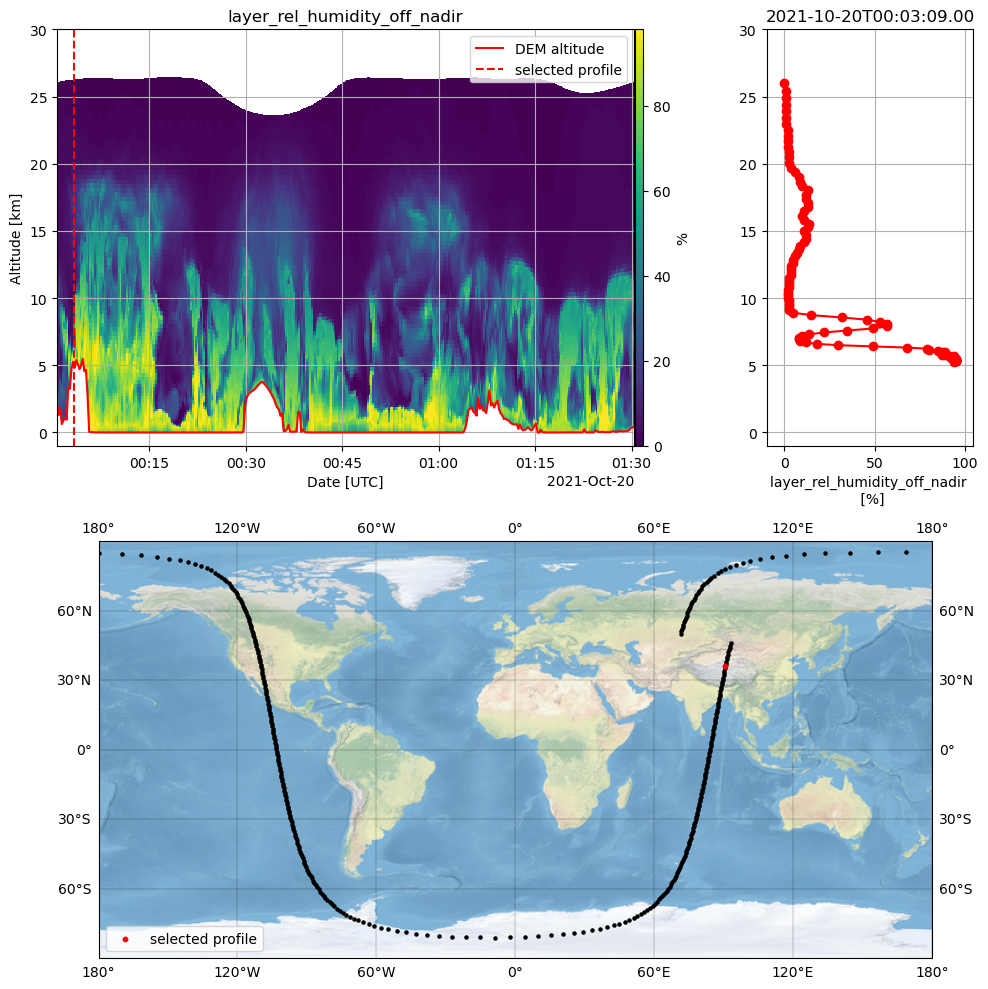

interactive(children=(SelectionSlider(continuous_update=False, description='Profile time', index=10, layout=La…

In [11]:
AUX_MET_plot.select_parameter(parameter="layer_rel_humidity", viewing_geometry="off-nadir")

# Apply QC filter
# Not important for AUX_MET data, since no invalid data occur
# AUX_MET_plot.apply_QC_filter()

# plot 2D curtain plot
# AUX_MET_plot.plot_2D()

# plot profile plot
# AUX_MET_plot.plot_profile(profile_time="2021-10-20T00:49:00", no_profiles_avg=0)

# plot interactive
AUX_MET_plot.plot_interactive(max_altitude=25, intermediate_profiles_to_skip=5)